In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
#import linearmodels as lms # Panel models
from statsmodels.tsa.stattools import adfuller
from numba import jit
import datetime
%matplotlib inline

# Read and clean data

This data is all hands played on each hour on the site restricted to subsets where either a player played both before and during shock or during and after.

In [404]:
# Full Sample (old)
#sessions_full = pd.read_csv('c:/users/matt/desktop/poker paper/sessions full sample.csv')
# Sample on ephemeral players only
#sessions = pd.read_csv('c:/users/matt/desktop/poker paper/suckers.csv')
# Regular players
#sessions = pd.read_csv('c:/users/matt/desktop/poker paper/sessions_prepared.csv')

sessions = pd.read_csv('c:/users/matt/desktop/poker paper/opponents.csv')

sessions = sessions.drop('Unnamed: 0', 1).drop(sessions.loc[:, 'Time^2':'logminutes'], 1)
sessions['Session Start'] = pd.to_datetime(sessions['Session Start'])

sessions['wage'] = (sessions['My C Won']/sessions['Minutes'])*60
sessions['BB call EV'] = (sessions['BB vs SB call won (bb)']/sessions['BB vs SB call cnt'])
sessions['BB 3b EV'] = (sessions['won when 3bet pre']/sessions['BB vs SB 3b cnt'])\
                        .replace([np.inf, -np.inf], np.nan).fillna(0.0)
sessions['BB continue EV'] =((sessions['BB vs SB call won (bb)'] + sessions['won when 3bet pre'])\
                            /(sessions['BB vs SB 3b cnt'] + sessions['BB vs SB call cnt']))\
                            .replace([np.inf, -np.inf], np.nan).fillna(0.0)

In [405]:
#
#
#
# Hands/minutes/sessions since treat
#
#
#


In [406]:
# set subsample!
#
#
sessions = sessions[sessions['ephemeral'] != 1]
sessions = sessions[sessions['t_cluster'] == 1]
#sessions = sessions[sessions['BB vs SB call cnt'] > 0]
#
#
#panel = sessions.set_index(['Session Start', 'Player'])

#daily_sessions = sessions.groupby(sessions.set_index('Session Start').index.date).mean()
#plt.plot(daily_sessions['My C Won'])

In [407]:
hourly = sessions.copy(deep=True)
hourly = hourly.drop(sessions.loc[:, 'Fold BB v SB':'during/after'], 1)\
                 .drop(sessions.loc[:, 'Time':'Time'], 1)

daily = sessions.copy(deep=True)
daily = daily.drop(sessions.loc[:, 'Fold BB v SB':'during/after'], 1)\
                 .drop(sessions.loc[:,'Midnight':'Time'], 1) 

hourly = hourly.set_index('Session Start')
daily = daily.set_index('Session Start')
daily_avg = daily.groupby(pd.TimeGrouper('1440Min')).mean()
hourly_avg = hourly.groupby(pd.TimeGrouper('60Min')).mean()
daily = daily.groupby(pd.TimeGrouper('1440Min')).sum()
hourly = hourly.groupby(pd.TimeGrouper('60Min')).sum()
hourly.loc[:, 'Treat':] = hourly_avg.loc[:, 'Treat':]
daily.loc[:, 'Treat':] = daily_avg.loc[:, 'Treat':]
hourly['wage'] = hourly_avg['wage']
daily['wage'] = daily_avg['wage']
hourly['Minutes avg'] = hourly_avg['Minutes']
daily['Minutes avg'] = daily_avg['Minutes']
hourly['Hands avg'] = hourly_avg['Hands']
daily['Hands avg'] = daily_avg['Hands']
hourly['My C Won avg'] = hourly_avg['My C Won']
daily['My C Won avg'] = daily_avg['My C Won']

hourly = hourly.fillna(0)
daily = daily.fillna(0)

In [408]:
# Clean Sessions dataset
sessions = sessions.sort_values(by='Session Start')
sessions = sessions.reset_index()
sessions = sessions.drop('index', 1)

In [409]:
# New dataset from grouped sessions average daily
daily_sessions = sessions.copy()
daily_sessions2 = sessions.copy()
daily_sessions = daily_sessions.groupby(daily_sessions.set_index('Session Start').index.date).mean()
daily_sessions2 = daily_sessions2.groupby(daily_sessions2.set_index('Session Start').index.date).median()
daily_sessions = daily_sessions.loc[:, :'Sunday']
daily_sessions['Minutes_median'] = daily_sessions2['Minutes']

# OLS on hands and rake aggregates

- Model on constant + dummies to test for intercept change

In [410]:
ols_est = sm.OLS(
        hourly['BB call EV'], 
        sm.add_constant(hourly.loc[:, 'Treat':'11PM']#.drop('After', 1)
    )).fit(cov_type='HC1')
#ols_est.summary()

In [411]:
# Output regressions
"""
for endog_name in ['My C Won', 'Hands', 'Hands avg', 'Minutes', 'Minutes avg', 'Sessions', 'My C Won avg', 'wage']:
    ols_est = sm.OLS(
        hourly[endog_name], 
        sm.add_constant(hourly.loc[:, 'Treat':'11PM']#.drop('After', 1)
    )).fit(cov_type='HC1')
    
    ols_summary = ols_est.summary()
    text_file = open(str("c:/users/matt/desktop/hourly " + endog_name + " k means.txt"), "w")
    text_file.write(ols_summary.as_text())
    text_file.close()
"""

'\nfor endog_name in [\'My C Won\', \'Hands\', \'Hands avg\', \'Minutes\', \'Minutes avg\', \'Sessions\', \'My C Won avg\', \'wage\']:\n    ols_est = sm.OLS(\n        hourly[endog_name], \n        sm.add_constant(hourly.loc[:, \'Treat\':\'11PM\']#.drop(\'After\', 1)\n    )).fit(cov_type=\'HC1\')\n    \n    ols_summary = ols_est.summary()\n    text_file = open(str("c:/users/matt/desktop/hourly " + endog_name + " k means.txt"), "w")\n    text_file.write(ols_summary.as_text())\n    text_file.close()\n'

In [412]:
#
# OLS with "Learning"
#
X3 = hourly.loc[:, 'After':'11PM']
X3 = X3.reset_index().drop('Session Start', 1)
# First cutoff @ 1453
X3['Week 1'] = ((X3.index >= 1453) & (X3.index < 1620)).astype(int)
X3['Week 2'] = ((X3.index >= 1620) & (X3.index < 1787)).astype(int)
X3['Week 3'] = ((X3.index >= 1787) & (X3.index < 1954)).astype(int)
X3['Week 4'] = ((X3.index >= 1954) & (X3.index < 2121)).astype(int)
X3['Week 5'] = ((X3.index >= 2121) & (X3.index < 2288)).astype(int)
X3['Week 6'] = ((X3.index >= 2288) & (X3.index < 2455)).astype(int)
X3['Week 7'] = ((X3.index >= 2455) & (X3.index < 2622)).astype(int)
X3['Week 8'] = ((X3.index >= 2622) & (X3.index < 2789)).astype(int)
X3['Week 9'] = ((X3.index >= 2789) & (X3.index < 2959)).astype(int)
# Second cutoff @ 2959

X3 = sm.add_constant(X3)

In [413]:
y_learn = hourly['BB call EV'].reset_index()['BB call EV']
ols_learn = sm.OLS(y_learn, X3).fit(cov_type='HC1')
#ols_learn.summary()

In [414]:
# Output regressions
"""
for endog_name in ['My C Won', 'Hands', 'Hands avg', 'Minutes', 'Minutes avg', 'Sessions', 'My C Won avg', 'wage']:
    y_learn = hourly[endog_name].reset_index()[endog_name]
    ols_learn = sm.OLS(y_learn, X3).fit(cov_type='HC1')
    
    ols_summary = ols_learn.summary()
    text_file = open(str("c:/users/matt/desktop/Hourly " + endog_name + " k means new -- Learn.txt"), "w")
    text_file.write(ols_summary.as_text())
    text_file.close()
"""

'\nfor endog_name in [\'My C Won\', \'Hands\', \'Hands avg\', \'Minutes\', \'Minutes avg\', \'Sessions\', \'My C Won avg\', \'wage\']:\n    y_learn = hourly[endog_name].reset_index()[endog_name]\n    ols_learn = sm.OLS(y_learn, X3).fit(cov_type=\'HC1\')\n    \n    ols_summary = ols_learn.summary()\n    text_file = open(str("c:/users/matt/desktop/Hourly " + endog_name + " k means new -- Learn.txt"), "w")\n    text_file.write(ols_summary.as_text())\n    text_file.close()\n'

# OLS on sessions panel (Fixed Effects)

In [416]:
"""
FE_panel = sm.add_constant(
          sessions.loc[:, 'Treat':].drop('wage', 1).drop('Time', 1)\
                  .join(pd.get_dummies(sessions['Player']))
            ).astype(float)
"""

#sessions = sessions[sessions['BB vs SB call cnt'] > 0]

FE_panel = pd.DataFrame(sessions['Player'])\
           .join(sessions['Opponent'])\
           .join(sessions.loc[:, 'Treat':'11PM'].astype(float))


for col in FE_panel.columns[2:]:
    FE_panel[col] -= FE_panel.groupby('Player')\
                             [col].transform('mean')
    FE_panel[col] -= FE_panel.groupby('Opponent')\
                             [col].transform('mean') 
        
        
FE_panel = sm.add_constant(FE_panel.drop('Player', 1)\
                              .drop('Opponent', 1))

FE_panel = FE_panel.loc[:, :'Treat'].join(
                    pd.get_dummies(sessions['k means opp']).iloc[:, 1])\
                    .join(sessions['ephemeral opp'].astype(float))
   
for endog_name in [#'Hands', 'My C Won', 'Minutes',
                   #'Sessions', 'wage', 
                   #'VPIP', 'CBet F', 'Total AF', '3Bet PF',
                   #'BB call EV',
                   #'BB continue EV',
                    'Fold BB v SB']:
    sessions_ols = sm.OLS(
        sessions[endog_name].fillna(0), 
        FE_panel
        ).fit(cov_type='HC1')   #NB: drop time if you want to

    ols_summary = sessions_ols.summary()
    text_file = open(str("c:/users/matt/desktop/PANEL " + endog_name + ".txt"), "w")
    text_file.write(ols_summary.as_text())
    text_file.close()

** Plots & Summary **

In [207]:
ddhands = hourly.reset_index()
ddhands['index'] = ddhands.index

fitted_hands = ols_est.fittedvalues.copy()
fitted_hands = fitted_hands.reset_index()
fitted_hands.columns = ['index', 'fit']

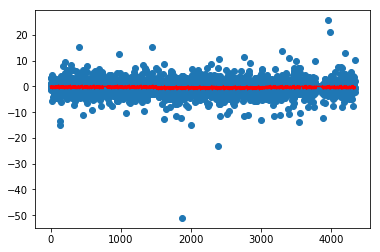

In [208]:
plt.scatter(ddhands.index, ddhands['BB call EV'])
plt.plot(fitted_hands['fit'], 'r')

# RDD

In [61]:
rddata_detrended_ev = pd.DataFrame(sessions_ols.resid)
rddata_detrended_ev['Treat'] = sessions['Treat']

rddata = sessions.copy(deep=True) #Cutoff is at 34286th observation

# Reset the index to create the forcing RDD variable
def reset_data_index(data_in):
    data_in = data_in.reset_index()
    data_in['index'] = data_in.index
    data_in['forcing'] = data_in.index
    return data_in


# Make index X-cutoff by finding location of cutoff
def get_cutoff_index(indata):
    for i in range(len(indata)):
        if indata['Treat'][i] == 0:
            continue
        return i

#
# HOUR data cleaning
#
rddata = reset_data_index(rddata)
cutoff_loc = get_cutoff_index(rddata)
rddata['index'] -= cutoff_loc

# Detrended
rddata_detrended_ev = reset_data_index(rddata_detrended_ev)
cutoff_loc = get_cutoff_index(rddata_detrended_ev)
rddata_detrended_ev['index'] -= cutoff_loc

In [62]:
def create_rd_indeces(indata):
    indata['index2'] = indata['index']**2
    indata['index3'] = indata['index']**3
    indata['treatIndex'] = indata['index'] * indata['Treat']
    indata['treatIndex2'] = rddata['index2'] * indata['Treat']
    indata['treatIndex3'] = indata['index3'] * indata['Treat']
    return indata

rddata = create_rd_indeces(rddata)
rddata_detrended_ev = create_rd_indeces(rddata_detrended_ev)

**ev RDD**

In [65]:
# deg 1
rd_hands_inter = smf.ols("BB call EV ~ Treat + index + treatIndex ", rddata).fit(cov_type='HC1')
rd_hands_inter_detrended = smf.ols("BB call EV ~ Treat + index + treatIndex ", rddata_detrended_ev).fit(cov_type='HC1')
# deg 2
rd_hands2_inter = smf.ols("BB call EV ~ Treat + index + index2 + treatIndex + treatIndex2", rddata).fit(cov_type='HC1')
rd_hands2_inter_detrended = smf.ols("BB call EV ~ Treat + index + index2 + treatIndex + treatIndex2",
                                    rddata_detrended_ev).fit(cov_type='HC1')
#deg 3
rd_hands3_inter = smf.ols("BB call EV ~ Treat + index + index2 + index3 + \
                            treatIndex + treatIndex2 + treatIndex3", rddata).fit(cov_type='HC1')
rd_hands3_inter_detrended = smf.ols("BB call EV ~ Treat + index + index2 + index3 + \
                            treatIndex + treatIndex2 + treatIndex3", rddata_detrended_ev).fit(cov_type='HC1')

rd_hands3_inter_daily.summary()

SyntaxError: invalid syntax (<unknown>, line 1)

In [159]:
"""
model_counter = 0

for endog_name in [rd_hands_inter, rd_hands_inter_detrended, rd_hands_inter_daily,\
                   rd_hands_inter_daily_detrended, rd_hands2_inter, rd_hands2_inter_detrended,\
                   rd_hands2_inter_daily, rd_hands2_inter_daily_detrended, rd_hands3_inter,\
                   rd_hands3_inter_detrended, rd_hands3_inter_daily, rd_hands3_inter_daily_detrended]:
    model_counter += 1    
    ols_summary = endog_name.summary()
    text_file = open(str("c:/users/matt/desktop/RDD Hands " + str(model_counter) + ".txt"), "w")
    text_file.write(ols_summary.as_text())
    text_file.close()
"""

** Plot **

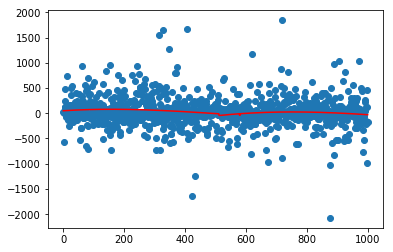

In [26]:
plt.scatter(rddata['forcing'], rddata['wage'])
plt.plot(rd_hands3_inter.fittedvalues, 'r')

# RD of 2nd cutoff

In [20]:
rddata2 = data.loc[2500:3500] #Cutoff is at 2959 observation
rddaily2 = daily.loc[85:155] #Cutoff is at 125nd obs

rddata2 = rddata2.reset_index()
rddata2['index'] = rddata2.index
rddata2['forcing'] = rddata2.index

rddata2['index'] -= get_cutoff_index(rddata2)

rddaily2 = rddaily2.reset_index()
rddaily2['index'] = rddaily2.index
rddaily2['forcing'] = rddaily2.index

rddaily2['index'] -= get_cutoff_index(rddaily2)